In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
import tensorflow as tf
import matplotlib.ticker as mticker
df = pd.read_csv('book.csv')
date_time = df.pop('date')
df = df.astype('float')
df.head()


,lable,open,high,low,close,volume,outstanding_share,turnover
0,0.0,13.50,14.38,13.07,13.15,54550924.0,88000000.0,0.619897
1,1.0,12.88,13.05,12.41,12.58,9800994.0,88000000.0,0.111375
2,2.0,12.88,13.38,12.65,13.33,5119657.0,88000000.0,0.058178
3,3.0,13.35,13.50,13.10,13.23,5988569.0,88000000.0,0.068052
4,4.0,13.15,13.50,13.08,13.28,3466311.0,88000000.0,0.039390


In [8]:
n = len(df)
train_split = int(0.7*n)
val_split = int(0.9*n)
df.head()

df_mean = df[:train_split].mean(axis=0)
df_std = df[:train_split].std(axis=0)
df = (df - df_mean)/df_std #标准化
df = df.values
target = df[:,5]
print(type(df))
print(df.shape)

<class 'numpy.ndarray'>
(4426, 8)


In [9]:
def window_generator(dataset, target, start_index, end_index, history_size, target_size):
    features = []
    labels = []
    if end_index is None:
        end_index = len(dataset) - target_size
    start_index +=history_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        features.append(dataset[indices])
        labels.append(target[i:i+target_size])
        
    return np.array(features),np.array(labels)

In [10]:
def loss_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs,loss,'b',label='Training Loss')
    plt.plot(epochs,val_loss,'r',label='Validation')
    plt.title('Loss')
    plt.legend()
    plt.show()
    

In [11]:
EPOCHS = 100  
EVALUATION_INTERNAL = 120
BATCH_SIZE = 100
BUFFER_SIZE = 2000
def compile_and_fit(model, train_data, val_data, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=patience,
        mode='auto',
        restore_best_weights=True)  
    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), 
                  loss='mae')  

    history = model.fit(train_data, epochs=EPOCHS,
                        steps_per_epoch=EVALUATION_INTERNAL,
                        validation_steps=50,
                        validation_data=val_data,
                        callbacks=[early_stopping])
    return history

In [16]:
X_train_single,y_train_single=window_generator(dataset=df,target=target,start_index=0,
                                               end_index=train_split,history_size=1,target_size=1)
X_val_single,y_val_single=window_generator(dataset=df,target=target,start_index=train_split,
                                               end_index=val_split,history_size=1,target_size=1)
X_test_single,y_test_single=window_generator(dataset=df,target=target,start_index=val_split,
                                            end_index=n-1,history_size=1,target_size=1)
X_train_multi,y_train_multi=window_generator(dataset=df,target=target,start_index=0,
                                          end_index=train_split,history_size=5,target_size=1)
X_val_multi,y_val_multi=window_generator(dataset=df,target=target,start_index=train_split,
                                          end_index=val_split,history_size=5,target_size=1)
X_test_multi,y_test_multi=window_generator(dataset=df,target=target,start_index=val_split,
                                           end_index=n-5,history_size=5,target_size=1)

In [17]:
print(X_train_multi.shape)
print(X_val_multi.shape)
print(X_test_multi.shape)
print(X_test_single.shape)

(3093, 5, 8)
(880, 5, 8)
(433, 5, 8)
(441, 1, 8)


In [32]:
train_single = tf.data.Dataset.from_tensor_slices((X_train_single,y_train_single))
val_single = tf.data.Dataset.from_tensor_slices((X_val_single,y_val_single))
train_multi = tf.data.Dataset.from_tensor_slices((X_train_multi,y_train_multi))
val_multi = tf.data.Dataset.from_tensor_slices((X_val_multi,y_val_multi))
train_single = train_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_single = val_single.cache().batch(BATCH_SIZE).repeat()
train_multi = train_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_multi = val_multi.cache().batch(BATCH_SIZE).repeat()

In [33]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

In [34]:
linear_history = compile_and_fit(linear,train_single,val_single)

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

120/120 [==============================] - 0s 2ms/step - loss: 0.9421 - val_loss: 0.7898
Epoch 2/100
120/120 [==============================] - 0s 1ms/step - loss: 0.5848 - val_loss: 0.5187
Epoch 3/100
120/120 [==============================] - 0s 914us/step - loss: 0.3984 - val_loss: 0.5669
Epoch 4/100
120/120 [==============================] - 0s 989us/step - loss: 0.3491 - val_loss: 0.5923
Epoch 5/100
120/120 [==============================] - 0s 1ms/step - loss: 0.3394 - val_loss: 0.5774

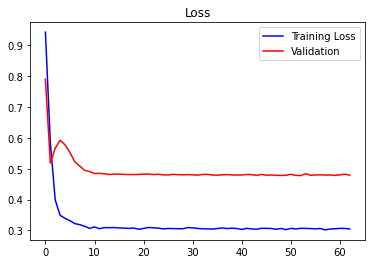

In [35]:
loss_curve(linear_history)

In [36]:
linear_result = linear.predict(X_test_single).reshape(-1,1)
fig = plt.figure(figsize=(15,8))
ax = plt.subplot2grid((3,3),(0,0),rowspan=3,colspan=3)
ax.xaxis.set_major_locator(mticker.MaxNLocator(10))
plt.plot(y_test_single,label='oringin')
plt.plot(linear_result,label='linear')
plt.legend()
plt.show()

AttributeError: 'Sequential' object has no attribute 'predic'